# Data analysis of Twitter API data

## Table of Contents
- [Introduction](#intro)
- [Part I - Gathering Data](#gathering)
- [Part II - Assessing Data](#assessing)
- [Part III - Cleaning Data](#cleaning)
- [Part IV - Data analysis](#analysis)

In [129]:
import os
import re
import pandas as pd
import numpy as np
import requests
import tweepy
import json
from timeit import default_timer as timer
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

<a id='intro'></a>
# Introduction
The dataset for the wrangling project (and analyzing and visualizing) is the tweet archive of Twitter user *@dog_rates*, also known as *WeRateDogs*. *WeRateDogs* is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." *WeRateDogs* has over 4 million followers and has received international media coverage.

## Project Motivation
### Context
Goal: wrangle *WeRateDogs* Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.
### Data
**Enhanced Twitter Archive**

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).
I extracted this data programmatically, but I didn't do a very good job. The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. You'll need to assess and clean these columns if you want to use them for analysis and visualization.

## Key points
Key points to keep in mind when data wrangling for this project:

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* Cleaning includes merging individual pieces of data according to the rules of tidy data.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of *WeRateDogs*.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

<a id='gathering'></a>
# Part I - Gathering Data

The relevant data is retrieved by getting each of the three pieces of data as described below:

1. The *WeRateDogs* Twitter archive, download this file manually by clicking the following link: [twitter_archive_enhanced.csv](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv)

2. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file `image_predictions.tsv` is hosted on Udacity's servers.

3. Additionaly, each tweet's retweet count and favorite ("like") count at minimum is gathered. Using the tweet IDs in the *WeRateDogs* Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt` file. Each tweet's JSON data is written to its own line. Then this .txt file is read line by line into a pandas DataFrame.

## 1. WeRateDogs Twitter archive
This table contains an information on the tweets from *WeRateDogs* Twitter archive up to August 1st, 2017.

In [4]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [3]:
df_archive.shape

(2356, 17)

In [4]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

## 2. Image predictions of a dog breed in the tweet

This table contains prediction info, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet.

Created according to a neural network, can be downloaded from Udacity's servers.

In [5]:
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# Extract file name
file_name = URL.split('/')[-1]

In [ ]:
# Save the data
r = requests.get(URL)
if r.ok:    
    with open(file_name, mode='wb') as file:
        file.write(r.content)

In [6]:
# Read the tab separated file
df_predictions = pd.read_csv(file_name, sep='\t')
df_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [ ]:
df_predictions.info()

## 3. Connecting to Twitter API
At this step with help of [Tweepy](http://www.tweepy.org/query) Python library we wil query Twitter's API for additional data beyond the data already included in the WeRateDogs Twitter archive file. This additional data will include retweet count and favorite count.

In order to replicate this code cell, one needs to open a Twitter account.

[Tweepy API Documentation](http://docs.tweepy.org/en/v3.2.0/api.html#API)

In [ ]:
# Set up the connection to Twitter API (requires Twitter account)
consumer_key = os.getenv('TW_CONSUMER_KEY')
consumer_secret = os.getenv('TW_CONSUMER_SECRET')

access_token = os.getenv('TW_ACCESS_TOKEN')
access_secret = os.getenv('TW_ACCESS_SECRET')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# Note the handling of Twitter rate limit may extend the tweet query time
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### Extract Tweet object data to a text file

In [ ]:
# Tweet IDs for which to gather additional data
tweet_ids = df_archive.tweet_id.values

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
failed_tweets_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as file:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    # Rate limits are divided into 15 minute intervals
    for tweet_id in tweet_ids:
        count += 1
        # print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            # print("Success")
            json.dump(tweet._json, file)
            file.write('\n')
        except tweepy.TweepError as e:
            print(f'Tweet id - {tweet_id} - does not exist anymore.\n')
            failed_tweets_dict[tweet_id] = e
            pass
end = timer()
print(f'Finished. Total execution time: {round((end - start) / 60, 2)} minutes\n')
print(f'Number of missing tweets: {len(failed_tweets_dict.items())}\n')

### Investigate Tweet object data

The tweet object data is based on the tweet IDs in the `twitter-archive-enhanced.csv` and stored as a [Tweet JSON Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/intro-to-tweet-json) in a text file.

In [ ]:
# Dictionary keys
tweet._json.keys()

In [ ]:
# Compare with the columns in the `twitter-archive-enhanced.csv`
df_archive.columns

In [ ]:
tweet._json

In [ ]:
tweet._json['full_text'][:139]

### Extract the number of Retweets and Favorite count
Code programmaticaly to count if a Tweet Object is a retweet and/or reply.

#### Load JSON Tweet objects created with Twitter API

In [7]:
# Create a list of tweet IDs dictionaries, retweets and replies
dict_list = []
retweet_list = [] 
reply_list = []

# Read .txt file as JSON file
with open('tweet_json.txt', 'r') as file:    
    for i, line in enumerate(file):       
        # Convert to Python dictionary
        data = json.loads(line)
        
        # Get tweet IDs if a tweet object is a retweet using regex
        if re.search(r'retweeted_status', line):
            retweet_list.append(data['id'])
        
        # Get reply tweet IDs
        if data['in_reply_to_status_id']:
            reply_list.append(data['id'])
            
        # Populate tweet dictionary
        dict_list.append({'tweet_id': data['id'],
                        'retweet_count': data['retweet_count'],
                        'favorite_count': data['favorite_count']                        
                        })
# Create a DataFrame with the the new parameters
df_stats = pd.DataFrame(dict_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
df_stats.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7730,36331
1,892177421306343426,5725,31313
2,891815181378084864,3787,23588
3,891689557279858688,7895,39641
4,891327558926688256,8515,37841


In [7]:
# Number or retweets, number of replies
len(retweet_list), len(reply_list)

(163, 77)

In [8]:
# Verify retweets in archive file
mask_retweets = df_archive.tweet_id.isin(retweet_list)
df_archive.loc[mask_retweets, ['tweet_id', 'text', 'retweeted_status_id']].sample(5)

,tweet_id,text,retweeted_status_id
250,845098359547420673,RT @dog_rates: This is Bungalo. She uses that ...,7.733088e+17
767,777641927919427584,RT @dog_rates: This is Arnie. He's a Nova Scot...,7.504293e+17
194,855245323840757760,RT @dog_rates: Meet George. He looks slightly ...,8.421635e+17
137,866094527597207552,RT @dog_rates: Here's a pupper before and afte...,8.378202e+17
589,799308762079035393,RT @dog_rates: I WAS SENT THE ACTUAL DOG IN TH...,7.743144e+17


In [9]:
# Verify replies in archive file
mask_retweets = df_archive.tweet_id.isin(reply_list)
df_archive.loc[mask_retweets, ['tweet_id', 'text', 'in_reply_to_user_id']].sample(5)

,tweet_id,text,in_reply_to_user_id
1905,674606911342424069,The 13/10 also takes into account this impecca...,4.196984e+09
346,831926988323639298,@UNC can confirm 12/10,2.068372e+07
1016,746906459439529985,"PUPDATE: can't see any. Even if I could, I cou...",4.196984e+09
274,840698636975636481,@0_kelvin_0 &gt;10/10 is reserved for puppos s...,8.405479e+17
1479,693582294167244802,Personally I'd give him an 11/10. Not sure why...,1.198989e+09


In [29]:
data

{'created_at': 'Sun Nov 15 22:32:08 +0000 2015',
 'id': 666020888022790149,
 'id_str': '666020888022790149',
 'full_text': 'Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj',
 'truncated': False,
 'display_text_range': [0, 131],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 666020881337073664,
    'id_str': '666020881337073664',
    'indices': [108, 131],
    'media_url': 'http://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg',
    'url': 'https://t.co/BLDqew2Ijj',
    'display_url': 'pic.twitter.com/BLDqew2Ijj',
    'expanded_url': 'https://twitter.com/dog_rates/status/666020888022790149/photo/1',
    'type': 'photo',
    'sizes': {'medium': {'w': 960, 'h': 720, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'large': {'w': 960, 'h': 720, 'resize': 'fit

<a id='assessing'></a>
# Part II - Assessing Data

After gathering each of the above pieces of data, they are assessed visually and programmatically for quality and tidiness issues. Detect and document at least:
    * (8) quality issues,
    * (2) tidiness issues.
    
To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header in [Introduction](#intro)) must be assessed.

## Quality assessment summary
In `df_archive`:
> 1. Columns `'doggo', 'floofer', 'pupper', 'puppo'` show that they have no missing values, however it is clear that 'None' in these columns are actual missing values that are not read in correctly by software. 
    * Furthermore, there are also a lot of values that are not register for any the dog stage category (all with 'None'), this means that the dog stage is also not categorized or mentioned in the tweet.
    * And some observations have two different dog stages registered
    * Columns `'doggo', 'floofer', 'pupper', 'puppo'` are of *object* type, could be converted to *category* type. However due to that there two dog stages in one observations, it will be kept as a string.

> 2. Columns like `'tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id'`are of *float64* or *int* type, must be converted to str type to be as no mathematical operations are not expected to perform. The same must be done for `'tweet_id'` in other DataFrames.

> 3. Column `'timestamp'` is of *object* type, must be converted to *datetime* type. Furthermore, these dates are formatted differently than the `'created_at'` time data from Tweet Object.

> 4. Validity issues with numerator and denominator data - some values are not extracted properly according to the rating system. Also both must be coverted to *float* type

In `df_predictions` and `df_stats`:
> 6. Number of rows in predictions and archive data don't match:
    * There are some replies or retweets 
    * Also there are also some tweets without the dog rating
    * Some tweets are expired and must be removed
     
> 7. Drop redundant columns like:
    * `'source'` which just shows the utility used to post the Tweet. For example, Tweets from the Twitter website have a source value of web.
    * `'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp' ` after filtering out the retweet and reply tweets
    
> 8. Filter the `df_predictions` and add only correct and highest predictions to the master file `df_master`
    * Correct dog prediction label formatting
    
    

**Additional comments** 

> Consistency of column names with the [Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object) attribute names in Tweet Data Dictionary. This may lead to confusion if someone else wants to extend the existing dataset. Rename the columns according to Tweet Object atributes:`'timestamp'` to `'created_at'` or with `'text'`  and `'full_text'`. However it is not implement in this exercise. 

## Tidiness assessment summary

1. In `df_archive` there are separate columns `'doggo', 'floofer', 'pupper', 'puppo'` that are one variable and must be melted together into a one column called `'dog_stage'`

2. Merge into one dataset : Add the new retweet and favorite data from `df_stats` , valid predictions from `df_predictions` to twitter archive data in `df_archive` and create one master file `df_master` and store as `twitter-archive-master.csv`.

### Quality: Different number of observations

In [30]:
# Number of tweets dont match
df_archive.shape[0], df_predictions.shape[0], df_stats.shape[0]

(2356, 2075, 2331)

In [31]:
# Number of missing tweets
df_archive.shape[0] - df_stats.shape[0]

25

### Quality: Validity of the rating system data

In [ ]:
# Validity issues with numerator and denominator data
df_archive.rating_denominator.value_counts()

In [ ]:
df_archive.rating_numerator.value_counts()

### Quality: Missing values and appropriate data types

In [ ]:
df_archive.sample(3, random_state=42)

In [ ]:
df_archive.info()

### Quality: Datetime columns

In [33]:
# Date format from archive
df_archive.timestamp[0]

'2017-08-01 16:23:56 +0000'

In [32]:
# Date format from Tweet object is different (only relevant if we keep this info)
data['created_at']

'Sun Nov 15 22:32:08 +0000 2015'

### Tiddiness:  Dog stage columns

In [ ]:
# Check the unique values in dog stage columns
dog_stage_columns = ['doggo', 'floofer', 'pupper', 'puppo']

for col in dog_stage_columns:
    print(df_archive[col].unique())

In [ ]:
# Some of the dog stage columns have two values for the same observation
index_list = list()
for index, row in df_clean[dog_stage_columns].iterrows():
    if row.nunique() > 1:
        print(row.values)
        # Collect indices with multiple dog stages
        index_list.append(index)

In [ ]:
index_list

In [ ]:
pd.options.display.max_colwidth = 100
# Investigate tweet text extraction with Two stages 
df_clean.loc[index_list, dog_stage_columns + ['text']]

### Quality: Predictions table

In [10]:
df_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [9]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
# Check for correct dog predictions
df_predictions.groupby('p1_dog').agg(['count', 'min', 'mean', 'max'])['p1_conf'].reset_index()

,p1_dog,count,min,mean,max
0,False,543,0.059033,0.540167,1.000000
1,True,1532,0.044333,0.613823,0.999956


In [21]:
df_predictions.groupby('p2_dog').agg(['count', 'min', 'mean', 'max'])['p2_conf'].reset_index()

,p2_dog,count,min,mean,max
0,False,522,1.011300e-08,0.11709,0.488014
1,True,1553,1.002880e-05,0.14047,0.467678


In [22]:
df_predictions.groupby('p3_dog').agg(['count', 'min', 'mean', 'max'])['p3_conf'].reset_index()

,p3_dog,count,min,mean,max
0,False,576,1.740170e-10,0.056893,0.255182
1,True,1499,1.434470e-06,0.061642,0.273419


In [14]:
# Print Top 10 predicted dogs labels
is_dog = df_predictions['p1_dog'] == True
df_predictions.loc[is_dog, 'p1'].value_counts().head(10)

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
malamute               30
Name: p1, dtype: int64

In [ ]:
# Check for duplicates tweets
df_predictions.tweet_id.duplicated().sum(), df_archive.tweet_id.duplicated().sum()

In [24]:
# Check if predictions contain information on the same tweets
df_predictions[['tweet_id']].append(df_archive[['tweet_id']]).tweet_id.unique().shape

(2356,)

In [166]:
df_archive.tweet_id.unique().shape[0], df_predictions.tweet_id.unique().shape[0]

(2356, 2075)

<a id='cleaning'></a>
# Part III - Cleaning Data

Clean each of the issues you documented while assessing.  The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.

In [57]:
# Create a Copy of the original data before cleaning
df_clean = df_archive.copy()
df_stats_clean = df_stats.copy()
df_predictions_clean = df_predictions.copy()

### Quality Issues - Convert ID columns from integer to strings
**Define:** Convert IDs from integer to float data type df.astype('object') in `df_clean`, `df_stats_clean`, `df_predictions_clean`

**Code:**

In [58]:
# Convert IDs in all 3 data sources
id_columns = ['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id']

df_clean[id_columns] = df_clean[id_columns].astype('str')
df_stats_clean['tweet_id'] = df_stats_clean['tweet_id'].astype('str')
df_predictions_clean['tweet_id'] = df_predictions_clean['tweet_id'].astype('str')

**Test:**

In [59]:
assert df_clean[id_columns].dtypes.all() == 'object'
assert df_stats_clean['tweet_id'].dtypes == 'object'
assert df_predictions_clean['tweet_id'].dtypes == 'object'

In [60]:
# Verify tweet ID data types to be string (object in Pandas)
df_clean[id_columns].dtypes.all(), df_stats_clean['tweet_id'].dtypes, df_predictions_clean['tweet_id'].dtypes

(dtype('O'), dtype('O'), dtype('O'))

### Quality Issues - Filter Retweets and Replies
**Define:** Filter retweets and replies from `df_archive_clean` and `df_stats_clean`

**Code:**

In [61]:
# Number of rows before removing
df_clean.shape[0], df_stats_clean.shape[0]

(2356, 2331)

In [62]:
# Convert extracted IDs for retweets and replies from integer to str
# Retweet and reply tweet ids were axtracted from Twitter API data (for df_stats)
retweet_list = list(map(str, retweet_list))
reply_list = list(map(str, reply_list))
drop_list = list(set(retweet_list + reply_list))

In [63]:
# Number of rows to drop from df_stats_clean
len(drop_list)

240

In [64]:
# Create mask
mask_drop_tweets = df_stats_clean['tweet_id'].isin(drop_list)
# Index with a mask
df_stats_clean = df_stats_clean.loc[~mask_drop_tweets]

**Test:**

In [65]:
assert df_stats_clean['tweet_id'].isin(drop_list).any() == False

In [66]:
# Number of rows after
df_stats_clean.shape[0]

2091

**Code:**

As the `df_stats_clean` is now filtered for the retweets, replies and does not contain the tweets that have been removed in Twitter, we can filter the `df_clean` based on the `df_stats_clean` remaining observations. 

Another way to filter out the would be based on the `in_reply_to_status_id` and `retweeted_status_id` in the archive table but the would be redundant, as the current method deals with the problem already.

In [67]:
# Number of rows before removing
df_clean.shape[0], df_stats_clean.shape[0] 

(2356, 2091)

In [68]:
# Create mask and filter
mask_tweets = df_clean['tweet_id'].isin(df_stats_clean['tweet_id'])
df_clean = df_clean.loc[mask_tweets]

**Test:**

In [69]:
# Number of rows after
assert df_clean.shape[0] == df_stats_clean.shape[0]

In [70]:
# Number of rows after
df_clean.shape[0]

2091

### Quality Issues - Convert date strings to datetime
**Define:** Convert strings to datetime object with pd.to_datetime(). Note date format is different in `df_archive` and `df_stats`

**Code:**

In [71]:
# Convert str to datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], format='%Y-%m-%d %H:%M:%S +0000')

In [72]:
# df_stats_clean
#df_stats_clean['created_at'] = pd.to_datetime(df_stats['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
#assert df_stats_clean['created_at'].dtypes == np.dtype('datetime64[ns]')

**Test:**

In [73]:
assert df_clean['timestamp'].dtypes == np.dtype('datetime64[ns]')

In [74]:
df_clean[['timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2091 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 32.7 KB


### Tidiness Issues - Dog Stage Columns
**Define:** Combine dog stage columns into one column named `'dog_stage'` with str methods, replace 'None' with '', afterwards remove it with Series.str.strip()

**Code:**

In [75]:
dog_stage_columns = ['doggo', 'floofer', 'pupper', 'puppo']
df_clean[dog_stage_columns] = df_clean[dog_stage_columns].replace(to_replace='None', value='')

In [76]:
# Check if all the 'None' values are removed
for col in dog_stage_columns:
    assert df_clean[col].any() != 'None'

In [77]:
df_clean['dog_stage'] = df_clean['doggo'] + df_clean['floofer'] + df_clean['pupper'] + df_clean['puppo']

# Then format entries with multiple dog stages.
df_clean.loc[df_clean['dog_stage'] == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
df_clean.loc[df_clean['dog_stage'] == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
df_clean.loc[df_clean['dog_stage'] == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

In [78]:
# Remove empty space character
df_clean['dog_stage'] = df_clean['dog_stage'].str.strip()

**Test:**

In [79]:
df_clean['dog_stage'].value_counts()

                 1756
pupper            221
doggo              71
puppo              23
doggo,pupper        9
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: dog_stage, dtype: int64

### Quality Issues - Convert Dog Stage to categorical
**Define:** Convert str to category with df.astype('category')

**Code:**

In [80]:
df_clean['dog_stage'] = df_clean['dog_stage'].astype('category')

**Test:**

In [81]:
# Check if all the 'None' values are removed'
assert df_clean['dog_stage'].dtypes == 'category'

In [82]:
# Verify that the dog stage columns are converted properly
df_clean[dog_stage_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   doggo    2091 non-null   object
 1   floofer  2091 non-null   object
 2   pupper   2091 non-null   object
 3   puppo    2091 non-null   object
dtypes: object(4)
memory usage: 81.7+ KB


### Quality Issues - Convert rating columns to float
**Define:** Convert numerator and denumenator from integer to float data type df.astype('float')

**Code:**

In [83]:
df_clean[['rating_numerator', 'rating_denominator']] = df_clean[['rating_numerator', 'rating_denominator']].astype('float')

**Test:**

In [84]:
assert df_clean[['rating_numerator', 'rating_denominator']].dtypes.all() == 'float'

In [85]:
df_clean[['rating_numerator', 'rating_denominator']].dtypes

rating_numerator      float64
rating_denominator    float64
dtype: object

### Quality Issues - Extract correct denominator values
**Define:** Read denominator values from tweet text column with Series.str.extract(regex)

**Code:**

In [86]:
regex = '((?:\d+\.)?\d+)\/(\d+)'
# Extract and create a DataFrame
rating = (df_clean.text.str.extract(regex, expand=True)
          .rename(columns={0: 'numerator', 1: 'denominator'})).astype('float')
rating.head(5)

,numerator,denominator
0,13.0,10.0
1,13.0,10.0
2,12.0,10.0
3,13.0,10.0
4,12.0,10.0


In [87]:
# Assign to dc_clean
df_clean[['rating_numerator', 'rating_denominator']] = rating[['numerator','denominator']]

**Test:**

In [88]:
assert df_clean[['rating_numerator', 'rating_denominator']].dtypes.all() == 'float'

df_clean['rating_numerator'].value_counts().head(5)

12.0    484
10.0    435
11.0    413
13.0    283
9.0     153
Name: rating_numerator, dtype: int64

In [89]:
df_clean['rating_denominator'].value_counts().head(5)

10.0     2074
50.0        3
80.0        2
11.0        2
150.0       1
Name: rating_denominator, dtype: int64

In [90]:
df_clean[['rating_numerator', 'rating_denominator']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rating_numerator    2091 non-null   float64
 1   rating_denominator  2091 non-null   float64
dtypes: float64(2)
memory usage: 49.0 KB


### Quality Issues - Drop unnecessary columns
**Define:** Remove columns that are not need for the analysis with df.drop()

**Code:**

In [91]:
columns_to_drop = list(['source', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo'])

df_clean = df_clean.drop(columns_to_drop, axis='columns')

df_clean.shape

(2091, 8)

In [92]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2091 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2091 non-null   object        
 1   timestamp           2091 non-null   datetime64[ns]
 2   text                2091 non-null   object        
 3   expanded_urls       2087 non-null   object        
 4   rating_numerator    2091 non-null   float64       
 5   rating_denominator  2091 non-null   float64       
 6   name                2091 non-null   object        
 7   dog_stage           2091 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(2), object(4)
memory usage: 133.1+ KB


**Test:**

In [93]:
for col in columns_to_drop:
    assert col not in df_clean.columns

In [94]:
df_clean.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

### Quality Issues - Format Dog prediction labels
**Define:** Use chained str atributes on string Series like: str.lower().str.replace().str.title()

**Code:**

In [95]:
# Format prediction columns
pred_id = ['p1', 'p2', 'p3']

df_predictions_clean[pred_id] = df_predictions_clean[pred_id].apply(lambda x: x.str.lower().str.replace('_', ' ').str.title())

**Test:**

In [96]:
# Verify that all words ar capitalized
assert df_predictions_clean[pred_id].applymap(lambda x: x[0].isupper() or x[1].isupper()).all().all()

# Verify that '_' is removed
assert df_predictions_clean[pred_id].apply(lambda x: x.str.contains('_')).all().all() == False

In [97]:
df_predictions_clean[pred_id].head(5)

,p1,p2,p3
0,Welsh Springer Spaniel,Collie,Shetland Sheepdog
1,Redbone,Miniature Pinscher,Rhodesian Ridgeback
2,German Shepherd,Malinois,Bloodhound
3,Rhodesian Ridgeback,Redbone,Miniature Pinscher
4,Miniature Pinscher,Rottweiler,Doberman


### Quality Issues - Select a Dog prediction 
**Define:** Choose a prediction of a dog label with df.apply(function) based on the following criteria that:
   * Firstly, a dog is actually predicted by neural network.
        * Secondly, probability of the prediction is higher than 20%.

**Code:**

In [98]:
# Function to select a prediction 


def select_prediction(df):    
    if df['p1_dog'] and df['p1_conf'] > 0.2:
        return df['p1']        
    elif df['p2_dog'] and df['p2_conf'] > 0.2:
        return df['p2']    
    elif df['p3_dog'] and df['p3_conf'] > 0.2:
        return df['p3']
    else:
        return 'Not a dog'
    

df_predictions_clean['prediction'] = df_predictions_clean.apply(select_prediction, axis = 1)

**Test:**

In [99]:
df_predictions_clean['prediction'].value_counts().head(10)

Not a dog             603
Golden Retriever      152
Labrador Retriever     99
Pembroke               90
Chihuahua              79
Pug                    56
Samoyed                44
Chow                   41
Toy Poodle             39
Pomeranian             37
Name: prediction, dtype: int64

### Tidiness Issues - Combine data 
**Define:** Combine `df_clean` into one master DataFrame df using pd.merge():
  * Add the retweet and favorite data from `df_stats_clean`
  * Add valid predictions from `df_predictions_clean` 
  * Create one master file `df_master` and store as `twitter-archive-master.csv` df.to_csv()

**Code:**

In [100]:
# Add retweet and favorite count
df_master_clean = pd.merge(df_clean, df_stats_clean, how='inner', on='tweet_id')

# Add images URLs and dog prediction labels
df_master = pd.merge(df_master_clean, df_predictions_clean[['tweet_id','prediction', 'jpg_url', 'img_num']], how='inner', on='tweet_id')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   object        
 1   timestamp           1964 non-null   datetime64[ns]
 2   text                1964 non-null   object        
 3   expanded_urls       1964 non-null   object        
 4   rating_numerator    1964 non-null   float64       
 5   rating_denominator  1964 non-null   float64       
 6   name                1964 non-null   object        
 7   dog_stage           1964 non-null   category      
 8   retweet_count       1964 non-null   int64         
 9   favorite_count      1964 non-null   int64         
 10  prediction          1964 non-null   object        
 11  jpg_url             1964 non-null   object        
 12  img_num             1964 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(2), i

**Test:**

In [101]:
# List of variables tha must be kept in the master CSV file
master_vars = ['tweet_id', 'timestamp', 'text', 'expanded_urls',
               'rating_numerator', 'rating_denominator', 
               'name', 'dog_stage',
               'retweet_count','favorite_count',
               'prediction', 'jpg_url', 'img_num']

# Verify that all desired variables are maintained
for col in df_master.columns:
    assert col in master_vars

In [102]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1964 non-null   object        
 1   timestamp           1964 non-null   datetime64[ns]
 2   text                1964 non-null   object        
 3   expanded_urls       1964 non-null   object        
 4   rating_numerator    1964 non-null   float64       
 5   rating_denominator  1964 non-null   float64       
 6   name                1964 non-null   object        
 7   dog_stage           1964 non-null   category      
 8   retweet_count       1964 non-null   int64         
 9   favorite_count      1964 non-null   int64         
 10  prediction          1964 non-null   object        
 11  jpg_url             1964 non-null   object        
 12  img_num             1964 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(2), i

## Saving Data

Save the clean DataFrame `df_master` in a CSV file named `twitter_archive_master.csv`.
I have chosen to save the 'False' predictions in the master file, however they will be filtered out during the analyis part.

In [103]:
df_master.to_csv('twitter-archive-master.csv', index=False)

<a id='analysis'></a>
# Part IV - Analyzing Data
In this part the most popular dogs are determined in the following categories:
1. Most popular Dog Breed
2. Most popular Dog Stage
3. Most frequent dog breed submission for rating



Reporting of the project can be also found here:
  1. Summary of data wrangling efforts are reported in `wrangle_report.html`.
  2. Summary of data analyses and visualizations are reported in `act_report.html`.

## Loading Data

Load the clean DataFrame(s) in a CSV file with the main one named `twitter_archive_master.csv`.

In [104]:
df = pd.read_csv('twitter-archive-master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1964 entries, 0 to 1963
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1964 non-null   int64  
 1   timestamp           1964 non-null   object 
 2   text                1964 non-null   object 
 3   expanded_urls       1964 non-null   object 
 4   rating_numerator    1964 non-null   float64
 5   rating_denominator  1964 non-null   float64
 6   name                1964 non-null   object 
 7   dog_stage           302 non-null    object 
 8   retweet_count       1964 non-null   int64  
 9   favorite_count      1964 non-null   int64  
 10  prediction          1964 non-null   object 
 11  jpg_url             1964 non-null   object 
 12  img_num             1964 non-null   int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 199.6+ KB


## Insights - Most Popular Dog Stage
Most popular dog stage (at least from the ones who are categorised) seems to be doggo and puppo, whereas fluffer and pupper are falling behind.

In [115]:
pd.set_option('display.precision', 1)
# Most popular dog stage by retweet or favorite count
(df.groupby('dog_stage').agg(['count', 'mean', 'max'])
 .loc[:, ['retweet_count']].round(0)
 .sort_values(('retweet_count', 'mean'), ascending=False)
 .reset_index()
 .style.background_gradient())

In [106]:
# Most popular dog stage by favorite count
(df.groupby('dog_stage').agg(['count', 'mean', 'max'])
 .loc[:, ['favorite_count']].round(0)
 .sort_values(('favorite_count', 'mean'), ascending=False)
 .reset_index()
 .style.background_gradient())

## Insights - Most Popular Dog Breeds
Based on the mean retweet count - **Afghan Hound** and based on the mean favorite count - **Saluki**.

However the predictions from neural network are not that correct as retrievers are also selected for thos categories, therefore the **Escimo Dog** and **French Bulldog** are selected as they are categorised better.

In [144]:
# Most popular dog label by retweet count
(df.query('prediction != "Not a dog"')
 .groupby('prediction').agg(['count', 'mean', 'max'])
 .loc[:, ['retweet_count']].round()
 .sort_values(('retweet_count', 'mean'), ascending=False)
 .reset_index()
 .head(10)
 .style.background_gradient())

In [143]:
# Most popular dog label by favorite count
(df.query('prediction != "Not a dog"')
 .groupby('prediction').agg(['count', 'mean', 'max'])
 .loc[:, ['favorite_count']].round()
 .sort_values(('favorite_count', 'mean'), ascending=False)
 .reset_index()
 .head(10)
 .style.background_gradient())

## Visualisations - Most Frequent Dog Breeds Submitted for Rating

It must be noted that almost 500 dogs where not categorized correctly by neural network.

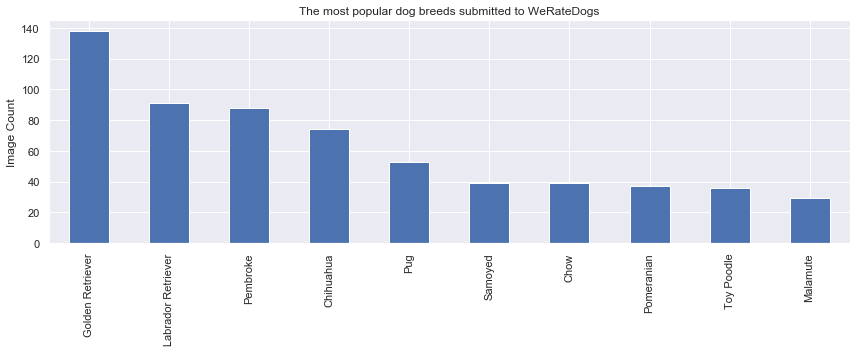

In [150]:
plt.figure(figsize=(12,5))
df.query('prediction != "Not a dog"').prediction.value_counts().head(10).plot(kind='bar');
plt.title('The most popular dog breeds submitted to WeRateDogs');
plt.ylabel('Image Count');
plt.tight_layout()

# Create folder for storing images
os.makedirs('Images', exist_ok=True)
plt.savefig('./Images/most_popular_dog_breeds.jpg')

In [141]:
# Most popular dog tweet
mask_max_fav = (df.favorite_count == df.favorite_count.max()) & (df.retweet_count == df.retweet_count.max())
df.loc[mask_max_fav]

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,favorite_count,prediction,jpg_url,img_num
763,744234799360020481,2016-06-18 18:26:18,Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13.0,10.0,None,doggo,78154,156838,Labrador Retriever,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1


### Downloading images
For Top 10 most popular dogs from each insight are saved.

In [111]:
# Create folder for storing images
os.makedirs('Images', exist_ok=True)

In [112]:
# Most popular dogs in category of most frequent dog rating submission
mask_golden_retriever = df.prediction == 'Golden Retriever'
df_golden_retriever = (df.loc[mask_golden_retriever, ['tweet_id', 'retweet_count', 'favorite_count', 'jpg_url']]
                      .nlargest(10, columns=['favorite_count']))
df_golden_retriever

,tweet_id,retweet_count,favorite_count,jpg_url
92,870374049280663552,24621,78783,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg
829,733109485275860992,16847,50151,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg
182,846514051647705089,11449,44355,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg
39,883482846933004288,9040,43116,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg
45,882268110199369728,10602,42189,https://pbs.twimg.com/media/DD5yKdPW0AArzX8.jpg
788,740373189193256964,13325,35050,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg
41,883117836046086144,6077,34902,https://pbs.twimg.com/media/DEF2-_hXoAAs62q.jpg
215,837820167694528512,7879,34264,https://pbs.twimg.com/media/C6CI_jbVAAA3-a1.jpg
438,796149749086875649,14684,33069,https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg
315,820749716845686786,10086,32089,https://pbs.twimg.com/media/C2PjgjQXcAAc4Uu.jpg


In [113]:
# Most popular dogs in category of most popular dog stage
mask_doggo_pupper = (df.dog_stage == 'doggo,puppo') | (df.dog_stage == 'doggo') | (df.dog_stage == 'puppo')            
df_doggo_pupper = (df.loc[mask_doggo_pupper, ['tweet_id', 'retweet_count', 'favorite_count', 'jpg_url']]
                      .nlargest(10, columns=['favorite_count']))
df_doggo_pupper

,tweet_id,retweet_count,favorite_count,jpg_url
763,744234799360020481,78154,156838,https://pbs.twimg.com/ext_tw_video_thumb/74423...
302,822872901745569793,44030,133560,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg
798,739238157791694849,57933,115827,https://pbs.twimg.com/ext_tw_video_thumb/73923...
326,819004803107983360,37575,88394,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg
290,825535076884762624,17774,57532,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg
442,795464331001561088,24327,50859,https://pbs.twimg.com/ext_tw_video_thumb/79546...
325,819006400881917954,19319,46074,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg
12,889665388333682689,9158,45191,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg
145,855851453814013952,17394,44535,https://pbs.twimg.com/media/C-CYWrvWAAU8AXH.jpg
182,846514051647705089,11449,44355,https://pbs.twimg.com/media/C79sB4xXwAEvwKY.jpg


In [157]:
# Images of the most popular dogs from each insight are saved

start = timer()

frames = {
    'puppo': df.query('dog_stage == "puppo"').nlargest(5, columns=['favorite_count']),
    'doggo': df.query('dog_stage == "doggo"').nlargest(5, columns=['favorite_count']),
    'doggo,puppo': df.query('dog_stage == "doggo,puppo"'),
    'golden_retriever': df_golden_retriever,
    'labrador_retriever': df.query('prediction == "Labrador Retriever"').nlargest(5, columns=['favorite_count']),    
    'french_bulldog': df.query('prediction == "French Bulldog"').nlargest(5, columns=['favorite_count']),
    'eskimo_dog': df.query('prediction == "Eskimo Dog"').nlargest(5, columns=['favorite_count'])
         }

for name, frame in frames.items():
    for i, (tweet_id, jpg_url) in enumerate(zip(frame.tweet_id, frame.jpg_url)):
        try:
            r = requests.get(jpg_url)
            # Download and save dog image
            img = Image.open(BytesIO(r.content))        
            img.save(f'./Images/{name}_{i+1}_{tweet_id}.jpg')

        except Exception as e:
            print(e)            
            pass
end = timer()

print(f'Finished. Total execution time: {round((end - start) / 60, 2)} minutes\n')

Finished. Total execution time: 0.12 minutes

